## Contents <a id='home'></a>
## [1. Loading the Dataset](#ltd)
## [2. Data Preprocessing](#dp)
## [3. Fine Tuning Bert](#ftb)
## [4. Test set](#ts)

The following code is used to fine-tune a transformer encoder model on headline popularity dataset.
For further information, please look at subsection III-C ([link](https://ieeexplore.ieee.org/abstract/document/10154027))

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import numpy as np
from sklearn.metrics import mean_squared_error
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import seaborn as sns
import pickle


In [3]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A6000


In [5]:
device = torch.device('cuda:0')
print(device)

cuda:0


# 2. loading the dataset <a id='ltd'></a>
[home](#home)

In [6]:
df_train_data = pd.read_feather('./ProcessedData/split/train.feather')
df_test_data = pd.read_feather('./ProcessedData/split/test.feather')
df_valid_data = pd.read_feather('./ProcessedData/split/valid.feather')

# MergedData = pd.read_csv('./ProcessedData/Proc_AllMergedData.txt')
# MergedData.head(2)

In [7]:
# df_train = df_train_data[df_train_data['author_name'] == 'The Guardian']
# len(df_train)
# df_valid = df_valid_data[df_valid_data['author_name'] == 'The Guardian']
# len(df_valid)
# df_test = df_test_data[df_test_data['author_name'] == 'The Guardian']
# len(df_test)

In [8]:
df_train = df_train_data
df_test = df_test_data
df_valid = df_valid_data

In [9]:
print(len(df_train))
print(len(df_test))
print(len(df_valid))

80070
4449
4448


In [10]:
df_valid.head(1)

,level_0,index,ID,post_text,truth_class,truth_mean,target_description,target_paragraphs,first_par,favorite_count,...,Pfirst_par,year,post_text1,post_text1_len,target_paragraphs_len,q9_outlier,q9_favorite_count,q9_favorite_count_norm,post_text_topic1,post_text_topic1_len
0,72821,82321,848173108171345922,Homeless man accused of murdering mother and s...,0.0,0.4,Homeless man accused of murdering mother and s...,A homeless man accused of murdering a woman a...,A homeless man accused of murdering a woman an...,2,...,A homeless man accused of murdering a woman an...,2017,Homeless man accused of murdering mother and s...,15,304,0,2.0,0.04878,homeless man accus murder mother son famili st...,74


In [11]:
df_test.head(1)

,level_0,index,ID,post_text,truth_class,truth_mean,target_description,target_paragraphs,first_par,favorite_count,...,Pfirst_par,year,post_text1,post_text1_len,target_paragraphs_len,q9_outlier,q9_favorite_count,q9_favorite_count_norm,post_text_topic1,post_text_topic1_len
0,10002,11283,793943285886840832,How custom in-ears stack up to earbuds,NaN,NaN,How Custom In-Ears Stack Up To Earbuds,In-ear monitors sound great on paper. But wha...,In-ear monitors sound great on paper. But what...,98,...,In-ear monitors sound great on paper. But what...,2016,How custom inears stack up to earbuds,7,381,0,98.0,0.224051,custom inear stack earbud,25


# 3. Data Preprocessing <a id='dp'></a>
[home](#home)

## 3.1 Bert Tokenizer

In [12]:
#Sentence Bert
#tokenizer = BertTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens", do_lower_case= True)

#Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [13]:
train_sentences = df_train.post_text1.values
train_labels = df_train.q9_favorite_count_norm.values
train_labels = [float(l) for l in train_labels]

In [14]:
valid_sentences = df_valid.post_text1.values
valid_labels = df_valid.q9_favorite_count_norm.values
valid_labels = [float(l) for l in valid_labels]

In [15]:
test_sentences = df_test.post_text1.values
test_labels = df_test.q9_favorite_count_norm.values
test_labels = [float(l) for l in test_labels]

In [16]:
#testing the tokenizer
# print('original= ', sentences[0])

# print('Tokenized= ', tokenizer.tokenize(sentences[0]))

# print('Token IDs= ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

# print('encoded = ', tokenizer.encode(sentences[0], add_special_tokens=True))


In [17]:
# max_len = max(CleanData['Post_len'])

# # for sentence in sentences:
    
# #     encoded = tokenizer.encode(sentence, add_special_tokens=True)
    
# #     max_len = max(max_len, len(encoded))
    
# print(max_len)

In [18]:
#tokenize all of the sentences

train_input_ids = []
train_attention_masks = []

test_input_ids = []
test_attention_masks = []

valid_input_ids = []
valid_attention_masks = []

#for every sentece
def tokenizer_all(sentences):
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_input = tokenizer.encode_plus(
                                sent,
                                add_special_tokens= True,
                                max_length= 52,
                                pad_to_max_length=True,
                                return_attention_mask= True,
                                return_tensors = 'pt')

        input_ids.append(encoded_input['input_ids'])


        attention_masks.append(encoded_input['attention_mask'])
    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenizer_all(train_sentences)
test_input_ids, test_attention_masks = tokenizer_all(test_sentences)
valid_input_ids, valid_attention_masks = tokenizer_all(valid_sentences)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/omidvar/anaconda3/envs/hugging5/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
train_input_ids[1].size()

torch.Size([1, 52])

In [20]:
   
#convert the lists into tensors
print(type(train_input_ids))
train_input_ids = torch.cat(train_input_ids, dim=0)
print(type(train_input_ids))    
train_attention_masks = torch.cat(train_attention_masks, dim=0)  
train_labels = torch.tensor(train_labels)

test_input_ids = torch.cat(test_input_ids, dim=0)    
test_attention_masks = torch.cat(test_attention_masks, dim=0)  
test_labels = torch.tensor(test_labels)

valid_input_ids = torch.cat(valid_input_ids, dim=0)    
valid_attention_masks = torch.cat(valid_attention_masks, dim=0)  
valid_labels = torch.tensor(valid_labels)

<class 'list'>
<class 'torch.Tensor'>


## 3.2 Training and Validation split
[home](#home)

In [21]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)

In [22]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 64

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
#             sampler = RandomSampler(train_dataset), # Select batches randomly
            sampler = SequentialSampler(train_dataset),
            batch_size = batch_size # Trains with this batch size.
    
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
valid_dataloader = DataLoader(
            valid_dataset, # The validation samples.
            sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [23]:
len(train_dataset) / batch_size

1251.09375

In [24]:
len(train_dataloader)

1252

# 4. Fine Tuning Bert <a id = 'ftb'></a>
[home](#home)

In [25]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1, # The number of output labels--1 for regression.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    #cache_dir= '/local/data1/omidvar/codes/HG/transformercashe'
)

# Tell pytorch to run this model on the GPU.
model.cuda(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [26]:
# Get all of the model's parameters as a list of tuples.

params = list(model.named_parameters())



print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')


for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')


for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')


for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2 Optimizer 

In [27]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                 eps = 1e-8)

/home/omidvar/anaconda3/envs/hugging5/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 20

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3 Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

In [29]:
# Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)

def mean_squared(preds, labels):
    return mean_squared_error(labels, preds)

Helper function for formatting elapsed times as hh:mm:ss

In [30]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [31]:


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

shutil.rmtree("./saved")
os.makedirs("./saved")
all_batch_loss = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    total_eval_loss1 = 0
    total_eval_accuracy1 = 0
    if epoch_i == 0:
        #see how model is working without training
        # Evaluate data for one epoch
        for batch in valid_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                result = model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels,
                               return_dict=True)

            loss = result.loss
            logits = result.logits

            # Accumulate the validation loss.
            total_eval_loss1 += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            #total_eval_accuracy += flat_accuracy(logits, label_ids)
            total_eval_accuracy1 += mean_squared(logits, label_ids)

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy1 / len(valid_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss1 / len(valid_dataloader)

        print("  Average Validation Loss: {}".format(avg_val_loss))



    
    
    
    
    
    
    
    
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    
    #Save the model
    if epoch_i % 1 == 0 and epoch_i != 0:
        os.makedirs('./saved/'+str(epoch_i))
        model.save_pretrained('./saved/'+str(epoch_i))
    
    
    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        
        all_batch_loss.append([epoch_i, step, loss.item()])
        
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.   loss:{}'.format(step, len(train_dataloader), elapsed,loss.item()))
        
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        #total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_accuracy += mean_squared(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Average Validation Loss: {}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  Accuracy: 0.54
  Average Validation Loss: 0.5379172772169113

======== Epoch 1 / 20 ========
Training...
  Batch    40  of  1,252.    Elapsed: 0:00:06.   loss:0.09429487586021423
  Batch    80  of  1,252.    Elapsed: 0:00:12.   loss:0.06839963048696518
  Batch   120  of  1,252.    Elapsed: 0:00:17.   loss:0.07527555525302887
  Batch   160  of  1,252.    Elapsed: 0:00:23.   loss:0.08199054002761841
  Batch   200  of  1,252.    Elapsed: 0:00:29.   loss:0.09851258993148804
  Batch   240  of  1,252.    Elapsed: 0:00:34.   loss:0.0870099812746048
  Batch   280  of  1,252.    Elapsed: 0:00:40.   loss:0.07940138131380081
  Batch   320  of  1,252.    Elapsed: 0:00:46.   loss:0.09776443243026733
  Batch   360  of  1,252.    Elapsed: 0:00:52.   loss:0.0708317905664444
  Batch   400  of  1,252.    Elapsed: 0:00:57.   loss:0.073236845433712
  Batch   440  of  1,252.    Elapsed: 0:01:03.   loss:0.057158246636390686
  Batch   480  of  1,252.    Elapsed: 0:01:09.   loss:0.08354362845420837
  Batch 

In [32]:
#model = BertForSequenceClassification.from_pretrained('./saved')

In [36]:
with open('./Logs/training_stats', 'wb') as f:
    pickle.dump(training_stats, f)


with open('./Logs/training_stats', 'rb') as f:
    training_stats = pickle.load(f)
    
#model = BertForSequenceClassification.from_pretrained('./saved')

In [37]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats.to_csv('./Logs/training_stats.csv')

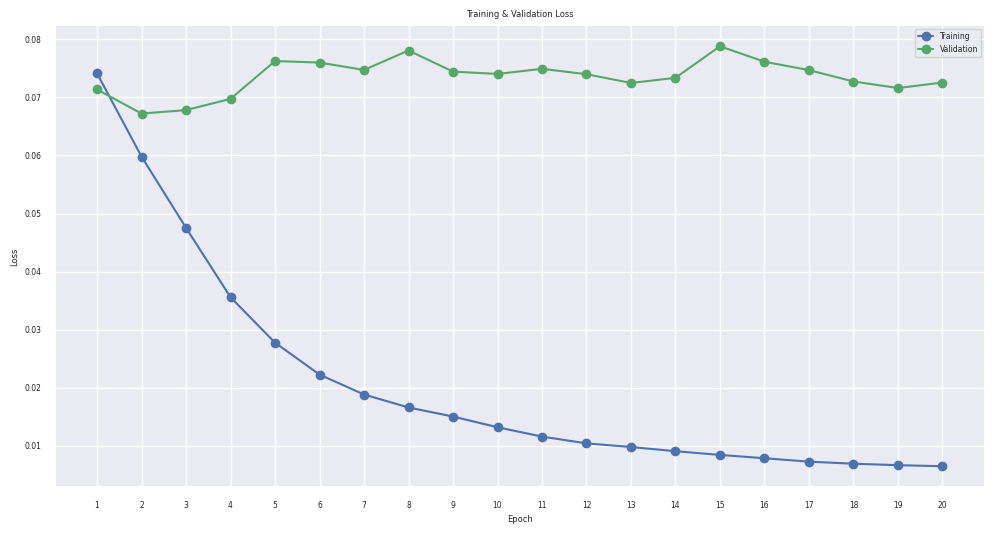

In [38]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=0.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

xticks_list = []
for i in range(len(training_stats)):
    xticks_list.append(i+1)

plt.xticks(xticks_list)

plt.savefig('./Logs/trainloss.jpg')

In [39]:
min(df_stats['Valid. Loss'])

0.06721799474741731

# 5. Test Set <a id='ts'></a>
[home](#home)

In [ ]:
epoch = 3

model_test = BertForSequenceClassification.from_pretrained('./saved/'+str(epoch))
tokenizer_test = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model_test = model_test.cuda()

In [ ]:
total_test_loss1 = 0
total_test_accuracy1 = 0

#see how model is working without training
# Evaluate data for one epoch
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():        
        result = model_test(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

    loss = result.loss
    logits = result.logits

    # Accumulate the validation loss.
    total_test_loss1 += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    #total_eval_accuracy += flat_accuracy(logits, label_ids)
    total_test_accuracy1 += mean_squared(logits, label_ids)

# Report the final accuracy for this validation run.
avg_test_accuracy = total_test_accuracy1 / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss1 / len(test_dataloader)

print("  Average test Loss: {}".format(avg_test_loss))


In [ ]:
def popularity_pred(model, tokenizer, sent, max_length = 104):

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 104,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_id = encoded_dict['input_ids']
    input_id = input_id.cuda()
    attention_mask = encoded_dict['attention_mask']
    attention_mask = attention_mask.cuda()
    model_test.eval()
    
    
    with torch.no_grad():
        result = model(input_id, 
                         token_type_ids=None, 
                         attention_mask=attention_mask,
                         return_dict=True)
    popularity = result.logits.data[0].item()
    a_max = 200
    a_min = 10
    if popularity > a_max:
        popularity = a_max
    elif popularity < a_min:
        popularity = a_min
    
    popularity = (popularity - a_min) / (a_max - a_min)
    
    return popularity

In [ ]:
def popularity_pred_batch(model, tokenizer, sents, max_length = 104):
    input_ids = []
    attention_masks = []

    for sent in sents:

        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 104,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    #convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)  
    attention_masks = torch.cat(attention_masks, dim=0)  

    input_ids = input_ids.cuda()
    attention_masks = attention_masks.cuda()

    model.eval()


    with torch.no_grad():
        result = model(input_ids, 
                         token_type_ids=None, 
                         attention_mask=attention_masks,
                         return_dict=True)

    popularity = result.logits.data.tolist()
    
    
    a_max = 200
    a_min = 10
    if popularity > a_max:
        popularity = a_max
    elif popularity < a_min:
        popularity = a_min

    popularity = (popularity - a_min) / (a_max - a_min)
    print(popularity)
    return result


In [ ]:
sent_idx = 1
sents = []

# sents.append(MergedData.post_text[sent_idx])
# print(MergedData.favorite_count[sent_idx])
# print(sents[0])


sents.append('Gunman kills at least 8 in mass shooting at California rail yard')

sents.append('Bitcoin is using lots of energy resources')
sents.append('CAD is using lots of energy resources')
sents.append('Trump is using lots of energy resources')
sents.append("What do you do? I'm scared!" )


In [ ]:
input_ids = []
attention_masks = []

In [ ]:
for sent in sents:

    encoded_dict = tokenizer_test.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 104,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [ ]:
#convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)  
attention_masks = torch.cat(attention_masks, dim=0)  

input_ids = input_ids.cuda()
attention_masks = attention_masks.cuda()

model_test.eval()

In [ ]:
with torch.no_grad():
    result = model_test(input_ids, 
                     token_type_ids=None, 
                     attention_mask=attention_masks,
                     return_dict=True)

popularity = result.logits.data.tolist()

In [ ]:
model_test?

In [ ]:
print(result.logits.data.tolist())

In [ ]:
result.logits.data.tolist()

In [ ]:
len(result.logits.data)

In [ ]:
print(popularity[0][0])

In [ ]:
def normalize_minmax(popularity, a_min = 10, a_max = 200):
    if popularity > a_max:
        popularity = a_max
    elif popularity < a_min:
        popularity = a_min 
    popularity = (popularity - a_min) / (a_max - a_min)
    return(popularity)
        
n_popularity = []
for i in popularity:
    print(i)
    n_popularity.append(normalize_minmax(i[0]))


In [ ]:
for i in range(len(result.logits.data )):
    result.logits.data[i] = normalize_minmax(result.logits.data[i])
print(result.logits.data)

In [ ]:
result.logits.data + 1 - result.logits.data

In [ ]:
baseline = [0.32, 0.10, 1, 0.5]

In [ ]:
baseline = torch.tensor(baseline)
baseline = baseline.cuda()
print(baseline)

In [ ]:
result.logits.data - baseline.view(4,1)

In [ ]:
print(result.logits.data.size())
print(baseline.view(4,1).size())

In [ ]:
print(n_popularity)

In [ ]:
n_popularity - baseline

In [ ]:
popularity = popularity_pred_batch(model_test, tokenizer_test, sents)

In [ ]:
print(popularity)

In [ ]:
popularity_pred(model_test, tokenizer_test, sents)

In [ ]:
for sent in sents:
    print(sent, popularity_pred(model_test, tokenizer_test, sent))

In [ ]:
tokenizer.encode_plus?

In [ ]:
torch.cat?

In [ ]:
import pickle
with open('./Logs/training_stats', 'rb') as f:
    training_stats = pickle.load(f)

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
# Display the table.
df_stats.to_csv('./Logs/training_stats.csv')

In [ ]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

xticks_list = []
for i in range(len(training_stats)):
    xticks_list.append(i+1)

plt.xticks(xticks_list)

plt.savefig('./Logs/trainloss.jpg')